# HA-ES Plotting

- udpated version of plotting script used for paper "..."

## General

- imports
- defintions
- loading data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygmo as pg
import seaborn as sns

import math
import os

from autorank._util import get_sorted_rank_groups
from autorank import autorank, plot_stats
from tabrepo import load_repository

method_id_name_dict = {
    "GES": "GES",
    "SINGLE_BEST": "Single-Best",
    "QO": "QO-ES",
    "QDO": "QDO-ES",
    "ENS_SIZE_QDO": "Size-QDO-ES",
    "INFER_TIME_QDO": "Infer-QDO-ES",
    "MEMORY_QDO": "Memory-QDO-ES",
    "DISK_QDO": "Diskspace-QDO-ES",
}
infer_time_weights = np.linspace(0, 1, num=15)[1:]
infer_time_weights = np.round(infer_time_weights, 2)
multi_ges_method_ids = [f"MULTI_GES-{time_weight:.2f}" for time_weight in infer_time_weights]
multi_ges_method_names = [f"Multi-GES({time_weight:.2f})" for time_weight in infer_time_weights]
for id, name in zip(multi_ges_method_ids, multi_ges_method_names):
    method_id_name_dict[id] = name

print("Loading data. This might take a while...")
df = pd.read_json("../data/full.json")

# Map method IDs to names
if "method" in df.columns:
    df["method_name"] = df["method"].map(method_id_name_dict)
else:
    raise ValueError("Column 'method' not found in DataFrame")
df = df.dropna(subset=['method_name'])
print(df.shape)
print(df.columns)
print(df["method_name"].unique())
print(df["method"].unique())

df["models_used_length"] = df["models_used"].apply(len)

Loading data. This might take a while...
(860233, 21)
Index(['name', 'iteration', 'roc_auc_val', 'roc_auc_test', 'models_used',
       'weights', 'time_weight', 'task', 'dataset', 'fold', 'method',
       'task_id', 'seed', 'inference_time', 'memory', 'disk_space',
       'negated_normalized_roc_auc', 'normalized_time', 'normalized_memory',
       'normalized_diskspace', 'method_name'],
      dtype='object')
['Multi-GES(0.71)' 'Multi-GES(0.64)' 'Multi-GES(0.21)' 'Multi-GES(0.36)'
 'Multi-GES(0.29)' 'GES' 'Multi-GES(1.00)' 'Multi-GES(0.93)'
 'Multi-GES(0.86)' 'Single-Best' 'Multi-GES(0.14)' 'Multi-GES(0.79)'
 'Multi-GES(0.43)' 'Multi-GES(0.07)' 'Multi-GES(0.50)' 'Multi-GES(0.57)']
['MULTI_GES-0.71' 'MULTI_GES-0.64' 'MULTI_GES-0.21' 'MULTI_GES-0.36'
 'MULTI_GES-0.29' 'GES' 'MULTI_GES-1.00' 'MULTI_GES-0.93' 'MULTI_GES-0.86'
 'SINGLE_BEST' 'MULTI_GES-0.14' 'MULTI_GES-0.79' 'MULTI_GES-0.43'
 'MULTI_GES-0.07' 'MULTI_GES-0.50' 'MULTI_GES-0.57']


## Helper Functions

### Boxplot:

In [2]:
import re

def extract_numeric_part(method_name):
    """
    Extracts the numeric part from a method name string. If no numeric part is found, returns None.
    """
    if isinstance(method_name, str):
        match = re.search(r"\((\d*\.?\d+)\)", method_name)
        if match:
            return float(match.group(1))
    return None

def boxplot(
    df: pd.DataFrame,
    y_str: str,
    log_y_scale: bool = False,
    log_x_scale: bool = False,
    flip_y_axis: bool = False,
    orient: str = "v",
    rotation_x_ticks: int = 45,
    outliers=False,
):
    if y_str not in df.columns:
        raise ValueError(f"Column '{y_str}' not found in DataFrame")
    
    # Ensure all values in 'method_name' are strings
    df["method_name"] = df["method_name"].astype(str)

    # Extract alphabetic part and numeric part from 'method_name' for sorting
    df["alphabetic"] = df["method_name"].apply(lambda x: re.split(r"\(\d*\.?\d+\)", x)[0])
    df["numeric"] = df["method_name"].apply(extract_numeric_part)
    
    # Sort by alphabetic part first, then numeric part (if any)
    df = df.sort_values(by=["alphabetic", "numeric"], ascending=[True, True])

    # Drop the temporary columns after sorting
    df = df.drop(columns=["alphabetic", "numeric"])

    # Plot ROC AUC scores for each method
    plt.figure(figsize=(8, 6))
    if orient == "v":
        sns.boxplot(
            data=df,
            x="method_name",  # or y='method_name' based on 'orient'
            y=y_str,
            hue="method_name",  # Assigning the variable to hue
            palette="pastel",
            linewidth=2,
            orient=orient,
            legend=False,  # Set legend to False if you don't need it
            showfliers=outliers,
        )
    elif orient == "h":
        sns.boxplot(
            data=df,
            x=y_str,
            y="method_name",  # or y='method_name' based on 'orient'
            hue="method_name",  # Assigning the variable to hue
            palette="pastel",
            linewidth=2,
            orient=orient,
            legend=False,  # Set legend to False if you don't need it
            showfliers=outliers,
        )
    else:
        raise ValueError(f"Orient '{orient}' not supported")

    if orient == "v":
        plt.ylabel(y_str)
        plt.xlabel("Ensemble Method")
    elif orient == "h":
        plt.xlabel(y_str)
        plt.ylabel("Ensemble Method")

    if log_y_scale:
        plt.yscale("log")
    if log_x_scale:
        plt.xscale("log")
    if flip_y_axis:
        plt.gca().invert_yaxis()

    plt.xticks(rotation=rotation_x_ticks)
    plt.grid(True)
    plt.tight_layout()

    # Check if the directory exists, if not, create it
    directory = "../plots"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save to file
    plt.savefig(f"{directory}/boxplot_{y_str}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{directory}/boxplot_{y_str}.pdf", dpi=300, bbox_inches="tight")
    plt.show()


import ipywidgets as widgets


def interactive_boxplot(df, column_options):
    y_str_widget = widgets.Dropdown(
        options=column_options,
        description="Y-axis column:",
        style={"description_width": "initial"},
    )
    log_y_scale_widget = widgets.Checkbox(value=False, description="Log-scale Y-axis")
    log_x_scale_widget = widgets.Checkbox(value=False, description="Log-scale X-axis")
    flip_y_axis_widget = widgets.Checkbox(value=False, description="Flip Y-axis")
    orient_widget = widgets.RadioButtons(
        options=["v", "h"],
        value="h",
        description="Orientation:",
        style={"description_width": "initial"},
    )
    rotation_x_ticks_widget = widgets.IntSlider(
        value=0, min=0, max=90, step=5, description="Rotation X-ticks"
    )

    ui = widgets.VBox(
        [
            y_str_widget,
            log_y_scale_widget,
            log_x_scale_widget,
            flip_y_axis_widget,
            orient_widget,
            rotation_x_ticks_widget,
        ]
    )

    out = widgets.interactive_output(
        boxplot,
        {
            "df": widgets.fixed(df),
            "y_str": y_str_widget,
            "log_y_scale": log_y_scale_widget,
            "log_x_scale": log_x_scale_widget,
            "flip_y_axis": flip_y_axis_widget,
            "orient": orient_widget,
            "rotation_x_ticks": rotation_x_ticks_widget,
        },
    )

    display(ui, out)

### Critical Difference:

In [3]:
def cd_evaluation(
    hypervolumes,
    maximize_metric=True,
    plt_title="Critical Difference Plot",
    filename="CriticalDifferencePlot.png",
):
    """
    hypervolumes: DataFrame with method names as columns and tasks as rows, each cell contains hypervolume.
    maximize_metric: Boolean, True if higher values are better.
    output_path: Where to save the plot, if None, plot will not be saved.
    plt_title: Title of the plot.
    """
    # Prepare data
    rank_data = -hypervolumes if maximize_metric else hypervolumes

    # Run autorank
    result = autorank(rank_data, alpha=0.05, verbose=False, order="ascending")

    # Plot with updated font size
    plt.close("all")
    width = 6
    fig, ax = plt.subplots(figsize=(12, width))
    plt.rcParams.update({"font.size": 20})

    plot_stats(result, ax=ax)
    ax.tick_params(axis="both", labelsize=20)  # Set font size for axis ticks
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
    plt.tight_layout()

    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

    return result


## Data Exploration

In [4]:
column_options = ["models_used_length", "roc_auc_test", "negated_normalized_roc_auc", "inference_time"]

#filtered_df = df[~df['method_name'].isin(['Multi-GES(0.43)', 'Multi-GES(0.50)'])].copy()
interactive_boxplot(df, column_options)

Output()

<Figure size 1000x600 with 0 Axes>

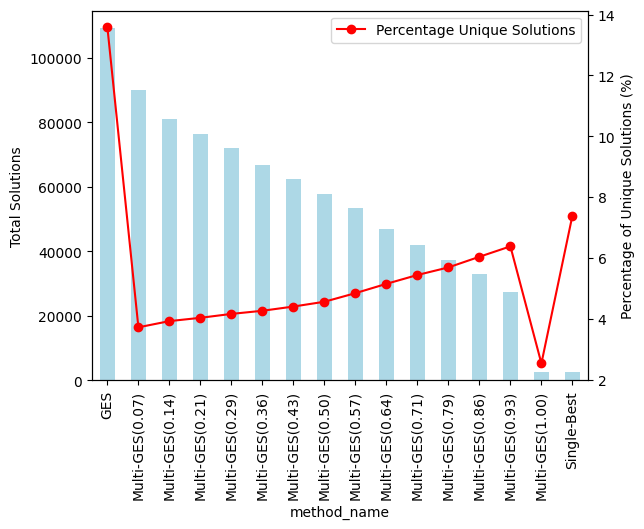

In [5]:
df['models_used_tuple'] = df['models_used'].apply(tuple)

# Group the DataFrame by 'method_name' and compute total and unique counts
result_df = df.groupby('method_name').agg(
    total_solutions=('models_used', 'count'),
    unique_solutions=('models_used_tuple', 'nunique')
)

# Calculate the percentage of unique solutions
result_df['percentage_unique_solutions'] = (
    result_df['unique_solutions'] / result_df['total_solutions'] * 100
)

# Optionally reset the index if you want 'method_name' as a column
result_df = result_df.reset_index()

# Plot the bar chart for total solutions
plt.figure(figsize=(10, 6))
ax = result_df.plot(kind='bar', x='method_name', y='total_solutions', color='lightblue', legend=False)

# Plot the percentage of unique solutions as a line graph
ax2 = ax.twinx()
ax2.plot(result_df['method_name'], result_df['percentage_unique_solutions'], color='red', marker='o', label='Percentage Unique Solutions')
ax2.set_ylabel('Percentage of Unique Solutions (%)')

# Set titles and labels
# ax.set_title("Total Solutions and Percentage of Unique Solutions per Method")
ax.set_ylabel("Total Solutions")
plt.xticks(rotation=90)
plt.legend()

plt.show()

## Pareto Front Eval

### True Pareto Front

In [6]:
def getParetoFront(df, objectives, return_mask=False):
    """
    Identify the Pareto-efficient points in the DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - objectives: list of objective column names.
    - return_mask: if True, return a boolean mask; else return indices.

    Returns:
    - Boolean mask or indices of Pareto-efficient points.
    """
    data = df[objectives].values
    is_efficient = np.ones(data.shape[0], dtype=bool)
    for i, c in enumerate(data):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(data[is_efficient] < c, axis=1)  # Keep any point with a lower value
            is_efficient[i] = True  # And keep self
    if return_mask:
        return is_efficient
    else:
        return np.where(is_efficient)[0]
    
def calculate_pareto_fronts(df, objectives):
    """
    Calculate the Pareto front points for all solutions in the DataFrame per task_id, seed, and fold.

    Parameters:
    - df: pandas DataFrame containing the data.
    - objectives: list of two objective column names.

    Returns:
    - A nested dictionary with structure {task_id: {seed: {fold: pareto_front_df}}}
    """
    if len(objectives) != 2:
        raise ValueError("Exactly two objectives must be provided.")

    # Initialize a dictionary to store the Pareto fronts
    pareto_fronts = {}

    # Iterate over unique task_ids
    for task_id in df["task_id"].unique():
        pareto_fronts[task_id] = {}

        # Iterate over unique seeds
        for seed in df["seed"].unique():
            pareto_fronts[task_id][seed] = {}

            # Iterate over unique folds
            for fold in df["fold"].unique():
                # Filter the DataFrame for the current task_id, seed, and fold
                df_fold = df[
                    (df["task_id"] == task_id)
                    & (df["seed"] == seed)
                    & (df["fold"] == fold)
                ]

                if df_fold.empty:
                    continue  # Skip if no data for this combination

                # Compute Pareto front for df_fold
                is_efficient = getParetoFront(df_fold, objectives, return_mask=True)
                pareto_front_df = df_fold[is_efficient]

                # Store the Pareto front DataFrame
                pareto_fronts[task_id][seed][fold] = pareto_front_df

    return pareto_fronts



def plot_pareto_fronts(pareto_fronts, df, objectives, seed_to_plot=0):
    """
    Plot Pareto fronts with outlined and semi-transparent points, only for the specified seed.

    Parameters:
    - pareto_fronts: nested dictionary with structure {task_id: {seed: {fold: pareto_front_df}}}
    - df: original DataFrame containing all points.
    - objectives: list of two objective column names.
    - seed_to_plot: the seed for which to plot Pareto fronts.
    """
    # Unpack objective names for labeling
    obj_x, obj_y = objectives

    point_size = 100  # Adjust point size as needed

    # Iterate over task_id and fold combinations for the specified seed
    for task_id, seeds in pareto_fronts.items():
        if seed_to_plot in seeds:
            for fold, pareto_front_df in seeds[seed_to_plot].items():
                # Filter out non-Pareto points
                df_fold = df[(df["task_id"] == task_id) & (df["seed"] == seed_to_plot) & (df["fold"] == fold)]
                non_pareto_df = df_fold[~df_fold.index.isin(pareto_front_df.index)]

                # Plot each Pareto front using Seaborn
                plt.figure(figsize=(10, 8))

                # Plot non-Pareto points in skyblue with a dark outline and semi-transparency
                sns.scatterplot(
                    x=non_pareto_df[obj_x],
                    y=non_pareto_df[obj_y],
                    color='skyblue',
                    edgecolor='black',
                    marker='o',
                    s=point_size,
                    alpha=0.6,
                    label='Non-Pareto points'
                )

                # Plot Pareto front points in darkred with a black outline and semi-transparency
                sns.scatterplot(
                    x=pareto_front_df[obj_x],
                    y=pareto_front_df[obj_y],
                    color='red',
                    edgecolor='black',
                    marker='o',
                    s=point_size,
                    alpha=0.8,
                    label='Pareto front points'
                )

                # Customize axis labels, title, and legend for readability
                plt.xlabel(obj_x, fontsize=14)
                plt.ylabel(obj_y, fontsize=14)
                plt.title(f'Pareto Front for Task {task_id}, Seed {seed_to_plot}, Fold {fold}', fontsize=16)
                plt.legend(fontsize=12)
                plt.grid(True)

                # Set axis limits to [0, 1]
                plt.xlim(0, 1)
                plt.ylim(0, 1)

                # Create directory if it doesn't exist and save the plot
                directory = f"../plots/pareto_fronts/{seed_to_plot}"
                if not os.path.exists(directory):
                    os.makedirs(directory)
                plt.savefig(f"{directory}/{task_id}_{fold}.png")
                plt.close()

In [7]:
# Define your objectives
objectives = ['negated_normalized_roc_auc', 'normalized_time']

# Calculate Pareto fronts
# pareto_fronts = calculate_pareto_fronts(df, objectives)

# plot_pareto_fronts(pareto_fronts, df, objectives)

### Hypervolume

In [8]:
def is_pareto_efficient(costs, return_mask=True):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        is_efficient[i] = not np.any(
            np.all(costs <= c, axis=1) & np.any(costs < c, axis=1)
        )
    return is_efficient if return_mask else costs[is_efficient]


def calculate_average_hypervolumes(df, method_name, objectives: list = ["negated_normalized_roc_auc", "normalized_time"]):
    if len(objectives) != 2: 
        return
    df_method = df[df["method_name"] == method_name]
    hypervolumes = {}

    # Iterate over unique task_ids
    for task_id in df_method["task_id"].unique():
        seed_hypervolumes = []  # Store hypervolumes for each seed

        for seed in df_method["seed"].unique():
            fold_hypervolumes = []  # Store hypervolumes for each fold under the current seed

            for fold in df_method["fold"].unique():
                df_fold = df_method[
                    (df_method["task_id"] == task_id)
                    & (df_method["seed"] == seed)
                    & (df_method["fold"] == fold)
                ]

                # Use a different variable name here
                objective_values = np.array(
                    [
                        df_fold[objectives[0]].values,
                        df_fold[objectives[1]].values,
                    ]
                ).T
                is_efficient = is_pareto_efficient(objective_values)
                efficient_objectives = objective_values[is_efficient]

                ref_point = [
                    1.01,
                    1.01,
                ]  # Reference point beyond the worst values of objectives
                hv = pg.hypervolume(efficient_objectives)
                hypervolume = hv.compute(ref_point)
                fold_hypervolumes.append(hypervolume)

            # Average hypervolumes across all folds for a given seed
            if fold_hypervolumes:
                average_fold_hypervolume = np.mean(fold_hypervolumes)
                seed_hypervolumes.append(average_fold_hypervolume)

        # Average the averaged fold hypervolumes across seeds
        if seed_hypervolumes:
            average_seed_hypervolume = np.mean(seed_hypervolumes)
            hypervolumes[task_id] = average_seed_hypervolume

    return hypervolumes



def find_non_dominated(points):
    """Identify the indices of non-dominated points."""
    is_efficient = np.ones(points.shape[0], dtype=bool)
    for i, c in enumerate(points):
        is_efficient[i] = not np.any(
            np.all(points <= c, axis=1) & np.any(points < c, axis=1)
        )
    return np.where(is_efficient)[0]


def plot_hypervolumes(all_hypervolumes, directory: str = "../plots/"):
    # Prepare the data for plotting
    methods = list(all_hypervolumes.keys())  # Method names
    hv_values = [list(all_hypervolumes[method].values()) for method in methods]
    data = []

    # Creating a DataFrame suitable for Seaborn
    for method_index, values in enumerate(hv_values):
        for value in values:
            data.append({"Method": methods[method_index], "Hypervolume": value})
    df = pd.DataFrame(data)

    # Calculate medians for each method and sort by median
    median_order = df.groupby("Method")["Hypervolume"].median().sort_values(ascending=False).index

    # Set the figure size and style
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Use seaborn's boxplot to plot the DataFrame, ordered by median values
    ax = sns.boxplot(
        y="Method", x="Hypervolume", data=df, hue="Method", palette="Set2",
        orient="h", order=median_order
    )

    # Set titles and labels
    ax.set_ylabel("Method", fontsize=20)
    ax.set_xlabel("Hypervolume", fontsize=20)

    # Set font size for ticks
    ax.tick_params(axis="x", labelrotation=45, labelsize=16)
    ax.tick_params(axis="y", labelsize=16)

    plt.tight_layout()
    plt.savefig(directory + "hypervolume_comparison.pdf", dpi=300)
    plt.savefig(directory + "hypervolume_comparison.png", dpi=300)
    plt.show()
    plt.close()

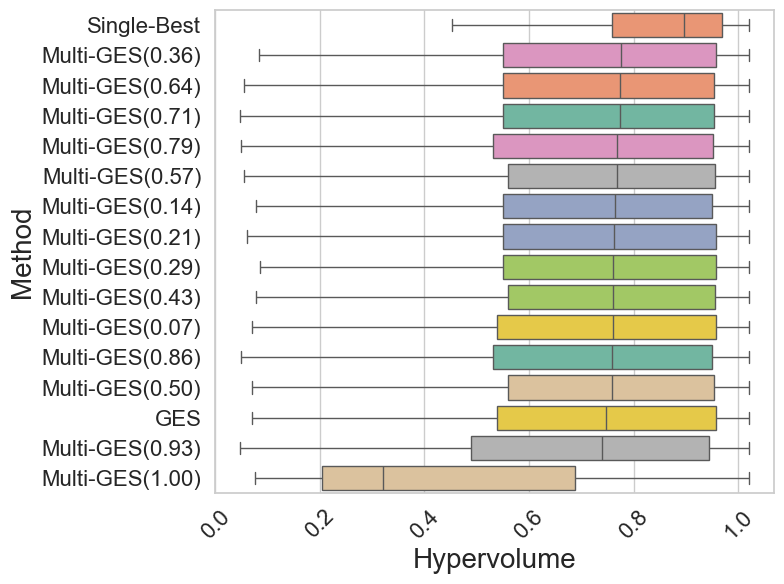

In [9]:
methods = df["method_name"].unique() #[
    # "GES",
    # "Multi-GES(0.00)"
    # "Single-Best",
    # "QDO-ES",
    # "Infer-QDO-ES",
    # "Size-QDO-ES",
    # "Memory-QDO-ES",
    # "Diskspace-QDO-ES",
# ]
all_hypervolumes = {}

for method in methods:
    all_hypervolumes[method] = calculate_average_hypervolumes(df, method, ["negated_normalized_roc_auc", "normalized_memory"])    

plot_hypervolumes(all_hypervolumes)
hypervolumes_df = pd.DataFrame(all_hypervolumes)
hypervolumes_df.to_csv("../data/hypervolumes.csv", index=False)

In [21]:
data = []
for method, tasks in all_hypervolumes.items():
    for task_id, hypervolume in tasks.items():
        data.append({"Task": task_id, "Method": method, "Hypervolume": hypervolume})

df_hypervolumes = pd.DataFrame(data)
pivot_hypervolumes = df_hypervolumes.pivot(
    index="Task", columns="Method", values="Hypervolume"
)

# Now you can use the modified cd_evaluation function
hv_result = cd_evaluation(
    pivot_hypervolumes,
    maximize_metric=True,
    plt_title="Hypervolume Critical Difference Plot",
    filename="../plots/CDPHypervolumes.pdf",
)
hv_result = cd_evaluation(
    pivot_hypervolumes,
    maximize_metric=True,
    plt_title="Hypervolume Critical Difference Plot",
    filename="../plots/CDPHypervolumes.png",
)
print(hv_result)

/home/jannis/Projects/HA-ES/venv/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/home/jannis/Projects/HA-ES/venv/lib/python3.10/site-packages/autorank/_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
/home/jannis/Projects/HA-ES/venv/lib/python3.10/site-packages/autorank/_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

RankResult(rankdf=
                  meanrank    median       mad  ci_lower  ci_upper  \
Method                                                               
GES               7.006024 -0.747993  0.212588 -0.949154 -0.530354   
Multi-GES(0.21)   7.240964 -0.762597  0.199507 -0.947492 -0.545892   
Multi-GES(0.29)   7.307229 -0.760781  0.201323 -0.947492 -0.545892   
Multi-GES(0.43)   7.397590 -0.760781  0.198786 -0.946071 -0.552942   
Multi-GES(0.50)   7.397590 -0.758434  0.195315 -0.946071 -0.552942   
Multi-GES(0.14)   7.536145 -0.764065  0.197497 -0.945398 -0.545892   
Multi-GES(0.36)   7.548193 -0.776346  0.188965  -0.94614 -0.545892   
Multi-GES(0.07)   7.650602 -0.760304  0.202481 -0.948935 -0.530354   
Multi-GES(0.57)   8.162651 -0.768422  0.192301  -0.94496 -0.552942   
Multi-GES(0.64)   9.006024 -0.773791  0.192864 -0.944866 -0.545892   
Single-Best       9.006024 -0.896151  0.102828   -0.9684 -0.757576   
Multi-GES(0.71)   9.174699 -0.773571  0.193113 -0.942441 -0.545892   
M

### Inverted Generational Distance

In [11]:
from pymoo.indicators.igd import IGD

def calculate_IGD_per_method(df, objectives):
    """
    Calculate the IGD for each method_name per task_id, seed, and fold.

    Parameters:
    - df: pandas DataFrame containing the data.
    - objectives: list of two objective column names.

    Returns:
    - DataFrame with columns [task_id, seed, fold, method_name, IGD].
    """
    results = []

    # Iterate over unique task_ids
    for task_id in df["task_id"].unique():
        # Iterate over unique seeds
        for seed in df["seed"].unique():
            # Iterate over unique folds
            for fold in df["fold"].unique():
                # Filter the DataFrame for the current task_id, seed, and fold
                df_fold = df[
                    (df["task_id"] == task_id)
                    & (df["seed"] == seed)
                    & (df["fold"] == fold)
                ]

                if df_fold.empty:
                    continue  # Skip if no data for this combination

                # Compute the reference Pareto front (from all methods)
                is_efficient = getParetoFront(df_fold, objectives, return_mask=True)
                reference_pareto_front = df_fold[is_efficient]
                pf_points = reference_pareto_front[objectives].values

                # Iterate over unique method_names
                for method_name in df_fold["method_name"].unique():
                    df_method = df_fold[df_fold["method_name"] == method_name]

                    # Compute Pareto front for df_method
                    is_efficient = getParetoFront(df_method, objectives, return_mask=True)
                    method_pareto_front = df_method[is_efficient]
                    method_points = method_pareto_front[objectives].values

                    if len(method_points) == 0 or len(pf_points) == 0:
                        igd_value = np.nan
                    else:
                        # Calculate IGD
                        ind = IGD(pf_points)
                        igd_value = ind(method_points)

                    # Append results
                    results.append({
                        "task_id": task_id,
                        "seed": seed,
                        "fold": fold,
                        "method_name": method_name,
                        "IGD": igd_value
                    })

    return pd.DataFrame(results)


def plot_IGD_values_with_medians(igd_results):
    """
    Plot the IGD values for each method, sorted by median IGD, and annotate the median values on the plot.

    Parameters:
    - igd_results: DataFrame with columns [task_id, seed, fold, method_name, IGD].
    """
    # Remove any NaN IGD values
    igd_results_clean = igd_results.dropna(subset=['IGD'])

    # Compute median IGD per method and sort methods
    median_igd = igd_results_clean.groupby('method_name')['IGD'].median().sort_values()
    sorted_methods = median_igd.index.tolist()

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(data=igd_results_clean, x='method_name', y='IGD', order=sorted_methods)
    
    # Annotate median values on top of the box plots
    for method in sorted_methods:
        median_val = median_igd[method]
        x = sorted_methods.index(method)  # Find the position on the x-axis
        y = median_val
        ax.text(x, y + 0.01, f'{median_val:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

    plt.title('IGD Values per Method (Sorted by Median IGD)')
    plt.ylabel('IGD')
    plt.xlabel('Method Name')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


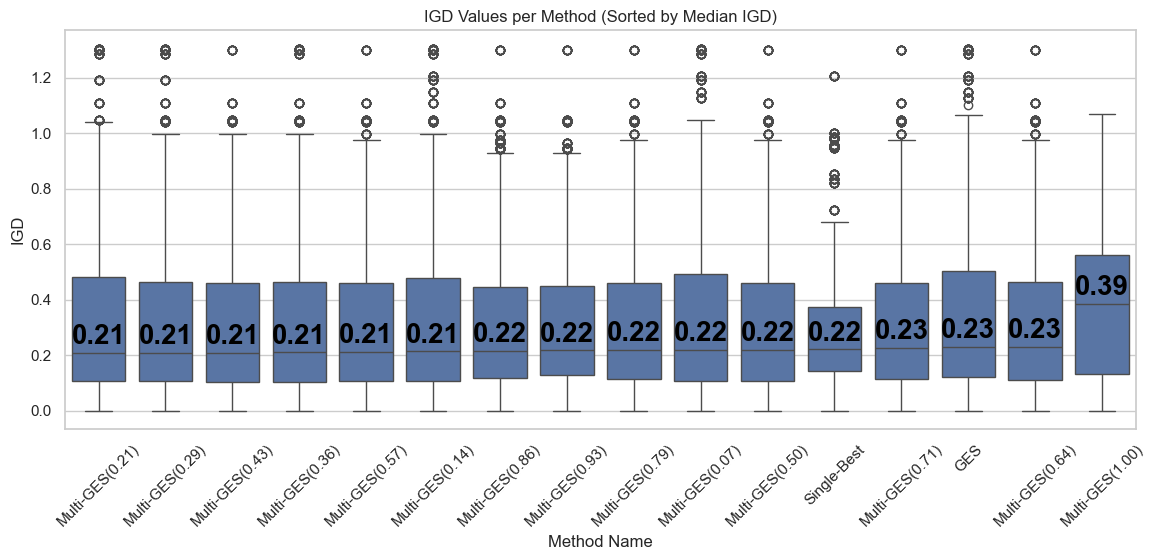

In [12]:
# Calculate IGD per method
igd_results = calculate_IGD_per_method(df, ["negated_normalized_roc_auc", "normalized_time"])

# Plot IGD values per method, sorted by median IGD, and annotate median values
plot_IGD_values_with_medians(igd_results)


In [13]:
# Group by 'method_name' and 'task_id', and aggregate with 'sum'
agg_igd = igd_results.groupby(["method_name", "task_id"]).agg('sum').reset_index()

# Pivot the data to have 'task_id' as the index and 'method_name' as columns
igd_pivots = agg_igd.pivot(
    index="task_id", columns="method_name", values="IGD"
)

# Perform the critical difference evaluation
igd_result = cd_evaluation(
    igd_pivots,
    maximize_metric=False,
    plt_title="Hypervolume Critical Difference Plot",
    filename="../plots/CDP_IGD.png",
)

# Repeat the same evaluation if necessary
igd_result = cd_evaluation(
    igd_pivots,
    maximize_metric=False,
    plt_title="Hypervolume Critical Difference Plot",
    filename="../plots/CDP_IGD.pdf",
)

/home/jannis/Projects/HA-ES/venv/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/home/jannis/Projects/HA-ES/venv/lib/python3.10/site-packages/autorank/_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
/home/jannis/Projects/HA-ES/venv/lib/python3.10/site-packages/autorank/_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

### Spacing

In [14]:
from scipy.spatial import distance_matrix

def calculate_spacing(pareto_front_df, objectives):
    points = pareto_front_df[objectives].values
    n_points = len(points)
    if n_points <= 2:
        return np.nan  
    dist_matrix = distance_matrix(points, points)
    np.fill_diagonal(dist_matrix, np.inf)
    min_distances = dist_matrix.min(axis=1)
    if np.any(min_distances == np.inf):
        return np.nan
    mean_distance = np.mean(min_distances)
    variance = np.sum((mean_distance - min_distances)**2) / (n_points - 1)
    return variance


def calculate_spacing_per_method(df, objectives):
    """
    Calculate the spacing for each method_name per task_id, seed, and fold.

    Parameters:
    - df: pandas DataFrame containing the data.
    - objectives: list of two objective column names.

    Returns:
    - DataFrame with columns [task_id, seed, fold, method_name, spacing].
    """
    results = []

    # Iterate over unique task_ids
    for task_id in df["task_id"].unique():
        # Iterate over unique seeds
        for seed in df["seed"].unique():
            # Iterate over unique folds
            for fold in df["fold"].unique():
                # Filter the DataFrame for the current task_id, seed, and fold
                df_fold = df[
                    (df["task_id"] == task_id)
                    & (df["seed"] == seed)
                    & (df["fold"] == fold)
                ]

                if df_fold.empty:
                    continue  # Skip if no data for this combination

                # Iterate over unique method_names
                for method_name in df_fold["method_name"].unique():
                    df_method = df_fold[df_fold["method_name"] == method_name]

                    # Compute Pareto front for df_method
                    is_efficient = getParetoFront(df_method, objectives, return_mask=True)
                    pareto_front_df = df_method[is_efficient]

                    # Calculate spacing
                    spacing = calculate_spacing(pareto_front_df, objectives)

                    # Append results
                    results.append({
                        "task_id": task_id,
                        "seed": seed,
                        "fold": fold,
                        "method_name": method_name,
                        "spacing": spacing
                    })

    return pd.DataFrame(results)


def plot_spacing_metrics(spacing_metrics_df):
    """
    Plot the spacing metrics using a bar plot, sorted by median spacing values.

    Parameters:
    - spacing_metrics_df: DataFrame with columns ['method_name', 'spacing']
    """
    # Calculate the median spacing for each method and sort by these values
    median_order = spacing_metrics_df.groupby("method_name")["spacing"].median().sort_values(ascending=False).index

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='method_name', y='spacing', data=spacing_metrics_df, showfliers=False, order=median_order)
    plt.title('Spacing per Method')
    plt.xlabel('Method Name')
    plt.ylabel('Spacing Metric')
    #plt.yscale('log')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

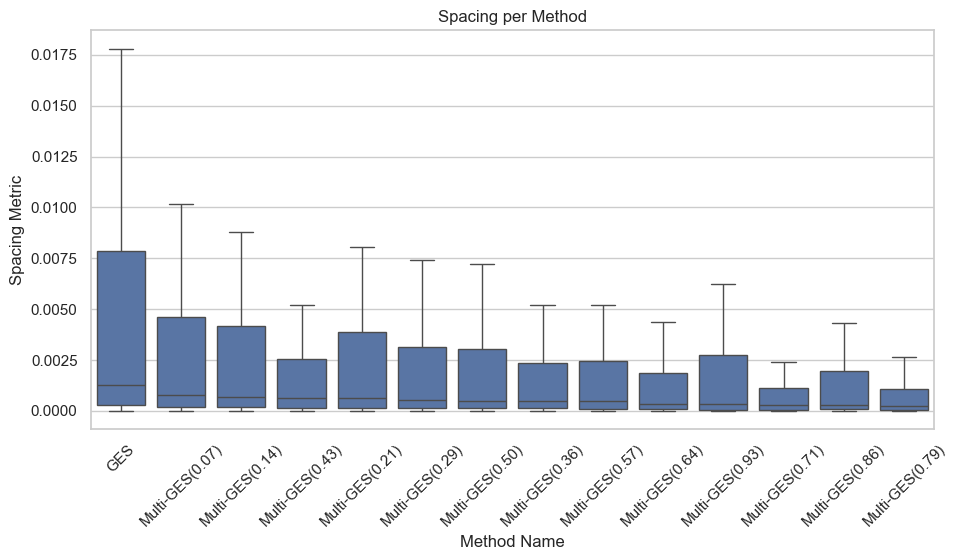

In [36]:
# Calculate the spacing results
spacing_results = calculate_spacing_per_method(df, ["negated_normalized_roc_auc", "normalized_time"])
spacing_results = spacing_results.dropna(subset=['spacing'])

# Display the resulting DataFrame
plot_spacing_metrics(spacing_results)

In [37]:
# Assuming you have a DataFrame 'spacing_results' similar to 'igd_results' that contains the 'spacing' values
# and the relevant columns: 'task_id', 'method_name', 'spacing'

# Group by 'method_name' and 'task_id', and aggregate by summing the spacing values
agg_spacing = spacing_results.groupby(["method_name", "task_id"]).agg('sum').reset_index()

# Pivot the data to have 'task_id' as the index and 'method_name' as columns for spacing values
spacing_pivots = agg_spacing.pivot(
    index="task_id", columns="method_name", values="spacing"
)

# Create a CDP plot for the spacing values
spacing_result = cd_evaluation(
    spacing_pivots,
    maximize_metric=False,
    plt_title="Spacing Critical Difference Plot",
    filename="../plots/CDP_Spacing.png",
)

# Optionally repeat the evaluation if necessary
spacing_result = cd_evaluation(
    spacing_pivots,
    maximize_metric=False,
    plt_title="Spacing Critical Difference Plot",
    filename="../plots/CDP_Spacing.pdf",
)

/home/jannis/Projects/HA-ES/venv/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/home/jannis/Projects/HA-ES/venv/lib/python3.10/site-packages/autorank/_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
/home/jannis/Projects/HA-ES/venv/lib/python3.10/site-packages/autorank/_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

### Putting It Together


#### Radar Chart

                      IGD   Spacing  Hypervolume
Method                                          
GES             -0.343840 -1.000000    -0.000000
Multi-GES(0.07) -0.085960 -0.770396    -0.132426
Multi-GES(0.14) -0.074499 -0.712022    -0.108911
Multi-GES(0.21) -0.054441 -0.628729    -0.048267
Multi-GES(0.29) -0.088825 -0.661281    -0.061881
Multi-GES(0.36) -0.153295 -0.461577    -0.111386
Multi-GES(0.43) -0.126074 -0.491011    -0.080446
Multi-GES(0.50) -0.147564 -0.530564    -0.080446
Multi-GES(0.57) -0.127507 -0.408822    -0.237624
Multi-GES(0.64) -0.202006 -0.215148    -0.410891
Multi-GES(0.71) -0.138968 -0.044665    -0.445545
Multi-GES(0.79) -0.044413 -0.039337    -0.513614
Multi-GES(0.86) -0.000000 -0.136971    -0.575495
Multi-GES(0.93) -0.110315 -0.000000    -0.693069
Multi-GES(1.00) -0.717765 -1.000000    -1.000000
Single-Best     -1.000000 -1.000000    -0.410891


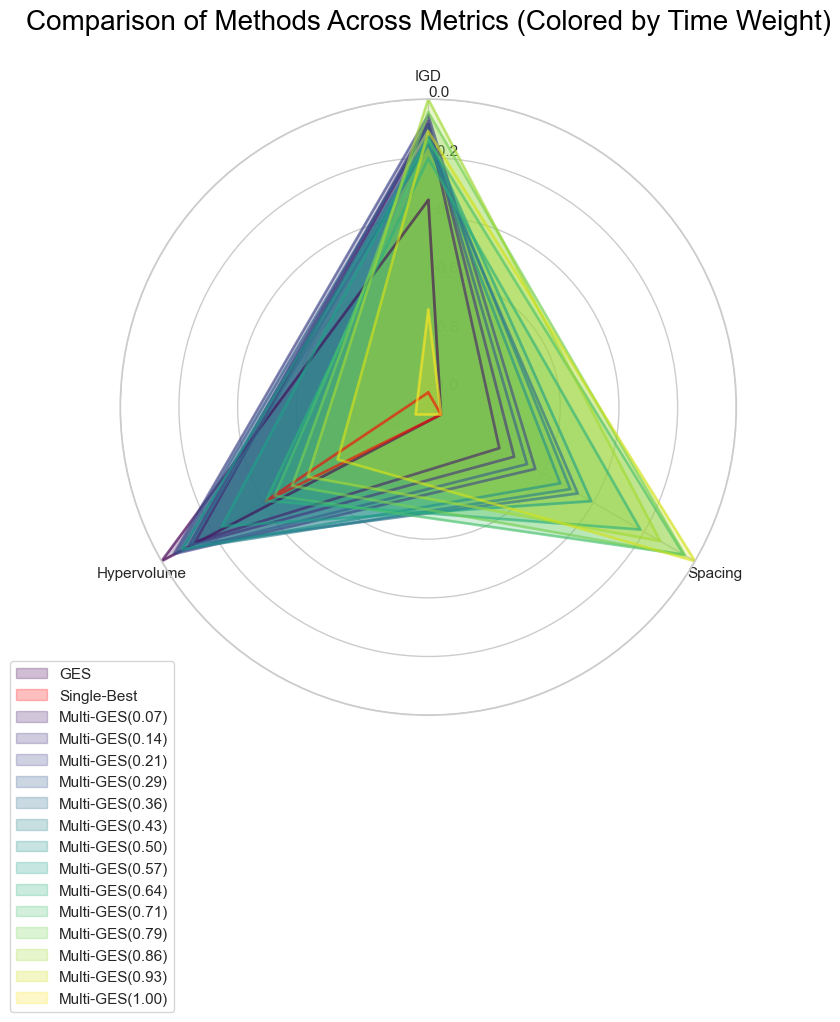

In [40]:
from math import pi
import re

# Extracting relevant values (meanrank) from each dataframe
metrics = ['Inverted Gen Dist', 'Spacing', 'Hypervolume']

# Sort each dataframe by the index (method) to ensure alignment
igd_sorted = igd_result.rankdf.sort_index()
spacing_sorted = spacing_result.rankdf.sort_index()
hv_sorted = hv_result.rankdf.sort_index()

# Combine the meanrank values, now correctly aligned by method
combined_df = pd.DataFrame({
    'Method': hv_sorted.index,
    'IGD': igd_sorted['meanrank'],
    'Spacing': spacing_sorted['meanrank'],
    'Hypervolume': hv_sorted['meanrank']
})

# Set 'Method' as the index
combined_df.set_index('Method', inplace=True)

# Normalize each metric independently
for metric in ['IGD', 'Spacing', 'Hypervolume']:
    combined_df[metric] = -(combined_df[metric] - combined_df[metric].min()) / (combined_df[metric].max() - combined_df[metric].min())
combined_df.loc['Multi-GES(1.00)', 'Spacing'] = -1
combined_df.loc['Single-Best', 'Spacing'] = -1

# Display the final normalized combined_df to verify correctness
print(combined_df)

# Function to extract the time weight from the method name
def extract_time_weight(method_name):
    if method_name == "GES":
        return 0.0
    match = re.search(r"\(([\d.]+)\)", method_name)
    if match:
        return float(match.group(1))
    return 0.0

# Create a time weight list based on method names
time_weights = [extract_time_weight(method) for method in combined_df.index]

# Sort the dataframe and the time weights based on the time weights
sorted_indices = np.argsort(time_weights)
combined_df = combined_df.iloc[sorted_indices]
time_weights = np.array(time_weights)[sorted_indices]

# Normalize the time weights for color mapping
norm_time_weights = (np.array(time_weights) - min(time_weights)) / (max(time_weights) - min(time_weights))

# Generate a colormap (e.g., using the 'viridis' colormap)
cmap = plt.get_cmap('viridis')

# Function to create a radar chart with color based on time weight
def create_radar_chart(df, title, time_weights, cmap):
    labels = df.columns
    num_vars = len(labels)

    # Compute angle of each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Make the plot circular
    angles += angles[:1]

    # Plot for each method
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for i, method in enumerate(df.index):
        values = df.loc[method].tolist()
        values += values[:1]  # Ensure the plot closes the circle
        
        if method == 'Single-Best':
            color = 'red'  # Use red color for 'Single-Best'
        else:
            color = cmap(norm_time_weights[i])  # Color based on time weight
        
        # Plot each method's radar plot with corresponding color
        ax.fill(angles, values, label=method, color=color, alpha=0.25)
        ax.plot(angles, values, linewidth=2, linestyle='solid', color=color, alpha=0.6)

    # Draw one axe per variable and add labels
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    ax.set_rlabel_position(0)
    plt.xticks(angles[:-1], labels)

    # Add title
    plt.title(title, size=20, color='black', y=1.1)

    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.show()

# Create the radar chart with color scale based on time weight
create_radar_chart(combined_df, "Comparison of Methods Across Metrics (Colored by Time Weight)", time_weights, cmap)

#### Parallel Coordinates Plot

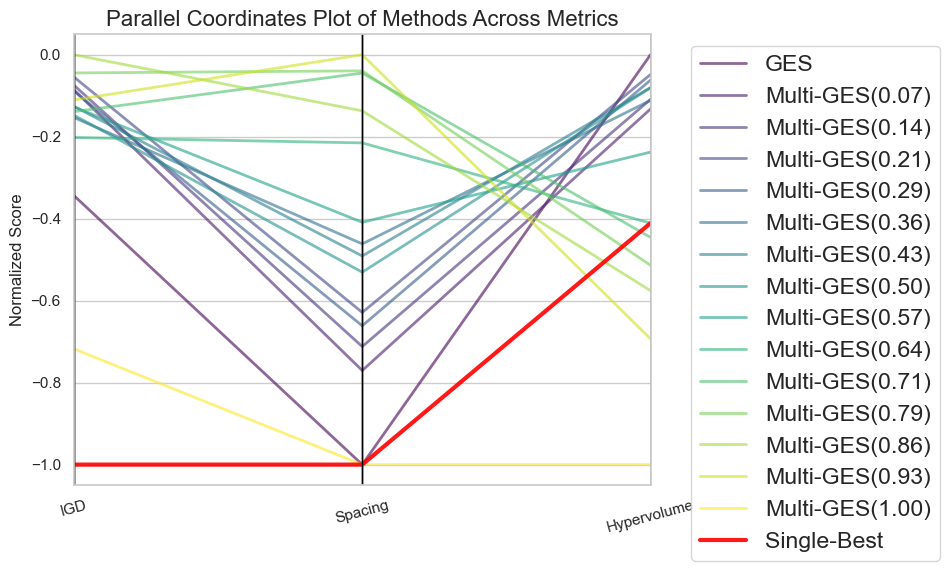

In [42]:
from pandas.plotting import parallel_coordinates

# Add a 'Method' column to use as the class in the parallel coordinates plot
combined_df['Method'] = combined_df.index

# Separate Single-Best for distinct coloring
single_best_df = combined_df[combined_df['Method'] == 'Single-Best']
other_methods_df = combined_df[combined_df['Method'] != 'Single-Best']

# Plot other methods with the colormap
plt.figure(figsize=(10, 6))
parallel_coordinates(other_methods_df, class_column='Method', colormap='viridis', alpha=0.6, linewidth=2)

# Overlay Single-Best in a distinct color (red) with a thicker line
parallel_coordinates(single_best_df, class_column='Method', color=['red'], alpha=0.9, linewidth=3)

# Add plot labels and title
plt.title('Parallel Coordinates Plot of Methods Across Metrics', fontsize=16)
plt.ylabel('Normalized Score')
plt.xticks(rotation=15)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Show plot
plt.tight_layout()
plt.show()


In [43]:
best_df = combined_df
best_igd_method = best_df.loc[best_df['IGD'].idxmax(), 'Method']
best_spacing_method = best_df.loc[best_df['Spacing'].idxmax(), 'Method']
best_hypervolume_method = best_df.loc[best_df['Hypervolume'].idxmax(), 'Method']

# Overall Best Performer (mean rank across all metrics)
best_df['Average_Rank'] = best_df[['IGD', 'Spacing', 'Hypervolume']].mean(axis=1)
best_overall_method = best_df.loc[best_df['Average_Rank'].idxmax(), 'Method']

best_df['IGD_deviation'] = (best_df['IGD'] - best_df['IGD'].mean()).abs()
best_df['Spacing_deviation'] = (best_df['Spacing'] - best_df['Spacing'].mean()).abs()
best_df['Hypervolume_deviation'] = (best_df['Hypervolume'] - best_df['Hypervolume'].mean()).abs()

# Summing the deviations to get a 'balance' score
best_df['Total_deviation'] = best_df[['IGD_deviation', 'Spacing_deviation', 'Hypervolume_deviation']].sum(axis=1)

# The method with the smallest total deviation is the most balanced
balanced_method = best_df.loc[best_df['Total_deviation'].idxmin(), 'Method']

# Reorganizing the final results
best_methods = {
    'Best Overall Performer': best_overall_method,
    'Best for IGD': best_igd_method,
    'Best for Spacing': best_spacing_method,
    'Best for Hypervolume': best_hypervolume_method,
    'Best Balanced Performer': balanced_method
}

best_methods


{'Best Overall Performer': 'Multi-GES(0.79)',
 'Best for IGD': 'Multi-GES(0.86)',
 'Best for Spacing': 'Multi-GES(0.93)',
 'Best for Hypervolume': 'GES',
 'Best Balanced Performer': 'Multi-GES(0.57)'}

### Pareto Front Topography

/tmp/ipykernel_21467/1975584543.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_21467/1975584543.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


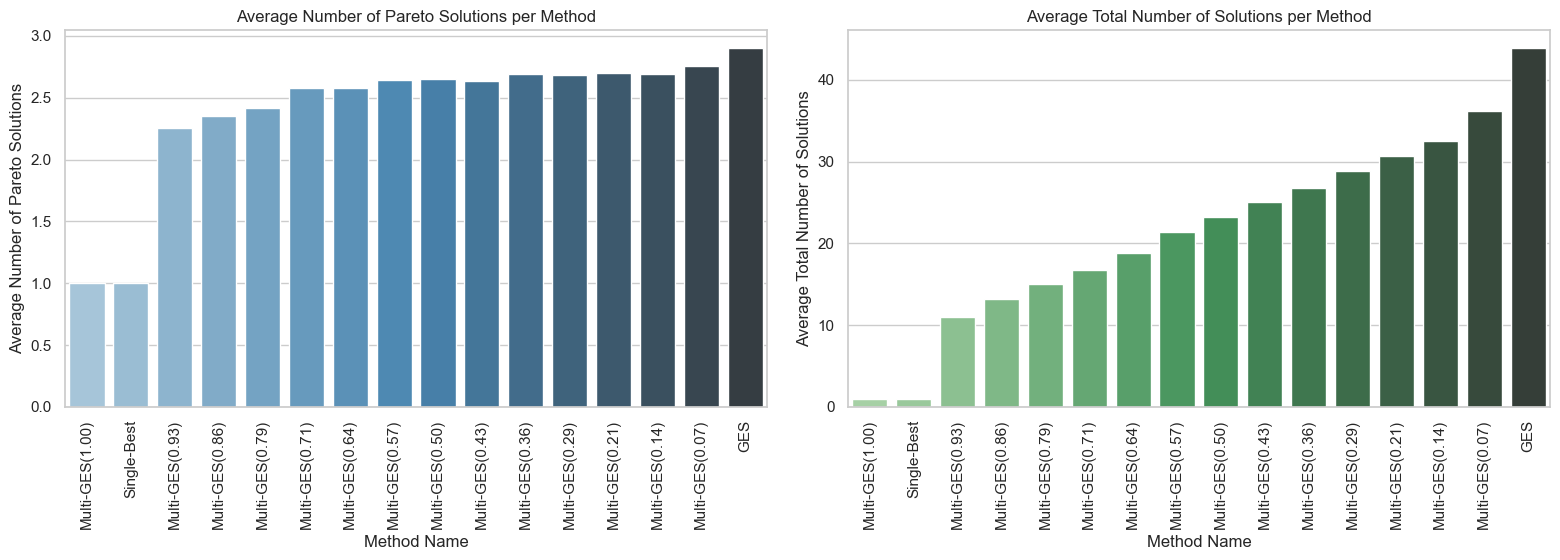

In [44]:
# Define your objectives
objectives = ['negated_normalized_roc_auc', 'normalized_time']

# Get unique method names
method_names = df["method_name"].unique()

# Calculate Pareto fronts for each method
method_pareto_fronts = {}
for method in method_names:
    df_method = df[df["method_name"] == method]
    method_pareto_fronts[method] = calculate_pareto_fronts(df_method, objectives)

# Function to count the number of solutions in Pareto fronts
def count_pareto_solutions(pareto_fronts):
    counts = {}
    for task_id in pareto_fronts:
        for seed in pareto_fronts[task_id]:
            for fold in pareto_fronts[task_id][seed]:
                pareto_front_df = pareto_fronts[task_id][seed][fold]
                n_solutions = len(pareto_front_df)
                key = (task_id, seed, fold)
                counts[key] = n_solutions
    return counts

# Count solutions in the method-specific Pareto fronts
method_pareto_counts = {}
for method in method_names:
    method_pareto_counts[method] = count_pareto_solutions(method_pareto_fronts[method])

# Calculate total number of solutions per method, task_id, seed, fold
total_counts = df.groupby(['method_name', 'task_id', 'seed', 'fold']).size().reset_index(name='total_solutions')

# Prepare data for plotting counts
data_list = []

# Add the method-specific Pareto fronts and total counts
for method in method_names:
    counts = method_pareto_counts[method]
    for key, n_solutions in counts.items():
        task_id, seed, fold = key
        # Get total number of solutions for this method, task_id, seed, fold
        total_solutions = total_counts[
            (total_counts['method_name'] == method) &
            (total_counts['task_id'] == task_id) &
            (total_counts['seed'] == seed) &
            (total_counts['fold'] == fold)
        ]['total_solutions'].values[0]
        data_list.append({
            'method_name': method,
            'task_id': task_id,
            'seed': seed,
            'fold': fold,
            'n_pareto_solutions': n_solutions,
            'total_solutions': total_solutions
        })

pareto_counts_df = pd.DataFrame(data_list)
pareto_counts_df['proportion_pareto'] = pareto_counts_df['n_pareto_solutions'] / pareto_counts_df['total_solutions']


# Calculate the average number of Pareto solutions per method
avg_pareto_solutions = pareto_counts_df.groupby('method_name')['n_pareto_solutions'].mean().reset_index()

# Calculate the average total number of solutions per method
avg_total_solutions = pareto_counts_df.groupby('method_name')['total_solutions'].mean().reset_index()

# Merge the averages into a single DataFrame
avg_counts_df = pd.merge(avg_pareto_solutions, avg_total_solutions, on='method_name')

# Sort methods by average total solutions for better visualization
avg_counts_df = avg_counts_df.sort_values('total_solutions')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot average number of Pareto solutions
sns.barplot(
    data=avg_counts_df,
    x='method_name',
    y='n_pareto_solutions',
    ax=axes[0],
    palette='Blues_d'
)
axes[0].set_title('Average Number of Pareto Solutions per Method')
axes[0].set_xlabel('Method Name')
axes[0].set_ylabel('Average Number of Pareto Solutions')
axes[0].tick_params(axis='x', rotation=90)

# Plot average total number of solutions
sns.barplot(
    data=avg_counts_df,
    x='method_name',
    y='total_solutions',
    ax=axes[1],
    palette='Greens_d'
)
axes[1].set_title('Average Total Number of Solutions per Method')
axes[1].set_xlabel('Method Name')
axes[1].set_ylabel('Average Total Number of Solutions')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


## Ranking

Picking best solutions...
Averaging over folds...
Averaging over seeds...
Shape after averaging: (1328, 7)


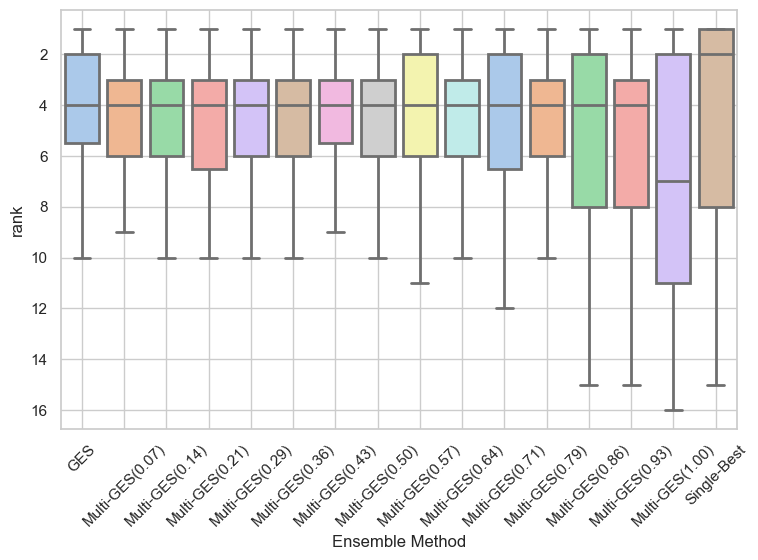

/home/jannis/Projects/HA-ES/venv/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/home/jannis/Projects/HA-ES/venv/lib/python3.10/site-packages/autorank/_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
/home/jannis/Projects/HA-ES/venv/lib/python3.10/site-packages/autorank/_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

RankResult(rankdf=                  meanrank    median       mad  ci_lower  ci_upper  \
method_name                                                          
Single-Best       7.301205  0.062500  0.055898  0.025432  0.164339   
Multi-GES(0.43)   7.765060  0.088201  0.081749  0.026923  0.290545   
Multi-GES(0.57)   7.867470  0.085365  0.079413  0.033004  0.305491   
Multi-GES(0.29)   8.012048  0.087664  0.081172  0.026923  0.305491   
GES               8.060241  0.087910  0.084159  0.032806  0.290799   
Multi-GES(0.36)   8.174699  0.087760  0.081268  0.026963  0.305491   
Multi-GES(0.14)   8.192771  0.087664  0.081172  0.026923  0.305491   
Multi-GES(0.21)   8.313253  0.087664  0.081172  0.027111  0.305491   
Multi-GES(0.50)   8.313253  0.087196  0.080803  0.026923  0.305491   
Multi-GES(0.71)   8.373494  0.089080  0.083368   0.03294  0.292147   
Multi-GES(0.64)   8.469880  0.087699  0.081988  0.033023  0.289537   
Multi-GES(0.79)   8.506024  0.089629  0.083875   0.03294  0.297102   
Mu

In [45]:
# DF with the best solution per task_id, fold, seed and method
print("Picking best solutions...")
idx = df.groupby(["method_name", "task_id", "fold", "seed"])["roc_auc_val"].idxmax()

# Use these indices to get the rows with the maximum 'roc_auc_val' for each group
best_val_scores = df.loc[idx]

print("Averaging over folds...")
avg_over_folds = (
    best_val_scores.groupby(["task_id", "method_name", "seed"])
    .agg(
        {
            "normalized_memory": "mean",
            "normalized_diskspace": "mean",
            "roc_auc_val": "mean",
            "roc_auc_test": "mean",
            "inference_time": "mean",
        }
    )
    .reset_index()
)
print("Averaging over seeds...")
avg_over_seeds = (
    avg_over_folds.groupby(["task_id", "method_name"])
    .agg(
        {
            "normalized_memory": "mean",
            "normalized_diskspace": "mean",
            "roc_auc_val": "mean",
            "roc_auc_test": "mean",
            "inference_time": "mean"
        }
    )
    .reset_index()
)

# Plot boxplot for inference time and performance
print(f"Shape after averaging: {avg_over_seeds.shape}")

# Rank data within each task based on 'roc_auc_test' and add as a new column
avg_over_seeds["rank"] = avg_over_seeds.groupby("task_id")["roc_auc_test"].rank(
    "dense", ascending=False
)
boxplot(avg_over_seeds, "rank", flip_y_axis=True)
avg_over_seeds["negated_roc_auc_test"] = 1 - avg_over_seeds["roc_auc_test"]
pivot_ranks = avg_over_seeds.pivot(
    index="task_id", columns="method_name", values="negated_roc_auc_test"
)
cd_evaluation(
    pivot_ranks,
    maximize_metric=False,
    plt_title="Rankings Critical Difference Plot",
    filename="../plots/CDPRankings.pdf",
)
cd_evaluation(
    pivot_ranks,
    maximize_metric=False,
    plt_title="Rankings Critical Difference Plot",
    filename="../plots/CDPRankings.png",
)

## Inference Time

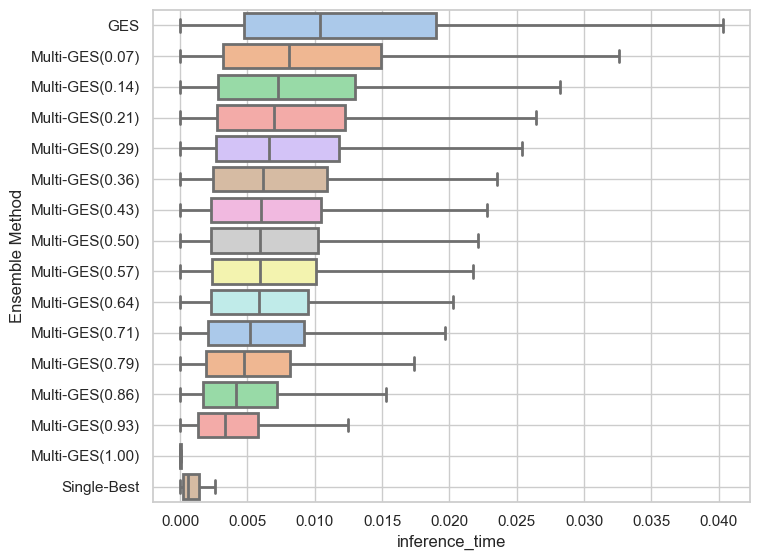

In [46]:
boxplot(
    df,
    "inference_time",
    log_x_scale=False,
    orient="h",
    rotation_x_ticks=0,
    outliers=False,
)

Higher variance for Multi-GES due to varying time weight

## Latex Table

In [ ]:
def create_latex_table(df, repo, filename="table.tex", max_char=15):
    methods = df["method_name"].unique()
    task_ids = df["task_id"].unique()

    with open(filename, "w") as f:
        f.write("\\begin{longtable}{l" + "c" * len(methods) + "}\n")
        f.write(
            "\\caption{Test ROC AUC - Binary: The mean and standard deviation of the test score over all folds for each method. The best methods per dataset are shown in bold. All methods close to the best method are considered best (using NumPy’s default \\texttt{isclose} function).}\n"
        )
        f.write("\\label{tab:results} \\\\ \n")
        f.write("\\toprule\n")
        f.write("Dataset & " + " & ".join(map(str, methods)) + " \\\\\n")
        f.write("\\midrule\n")
        f.write("\\endfirsthead\n")
        f.write("\\toprule\n")
        f.write("Dataset & " + " & ".join(map(str, methods)) + " \\\\\n")
        f.write("\\midrule\n")
        f.write("\\endhead\n")
        f.write("\\midrule\n")
        f.write(
            "\\multicolumn{"
            + str(len(methods) + 1)
            + "}{r}{Continued on next page} \\\\\n"
        )
        f.write("\\midrule\n")
        f.write("\\endfoot\n")
        f.write("\\bottomrule\n")
        f.write("\\endlastfoot\n")

        for task_id in task_ids:
            dataset_name = repo.tid_to_dataset(
                task_id
            )  # Convert task_id to dataset name
            truncated_name = (
                (dataset_name[:max_char] + "...")
                if len(dataset_name) > max_char
                else dataset_name
            )
            escaped_name = truncated_name.replace("_", "\\_")  # Escape underscores
            line = [str(escaped_name)]  # Ensure the first item is a string
            method_scores = []

            for method in methods:
                method_data = df[
                    (df["task_id"] == task_id) & (df["method_name"] == method)
                ]
                if not method_data.empty:
                    mean_score = method_data["roc_auc_test"].mean()
                    std_dev = method_data["roc_auc_test"].std()
                    score_str = f"{mean_score:.4f}($\\pm${std_dev:.4f})"
                    method_scores.append((mean_score, score_str))
                else:
                    method_scores.append((None, "-"))

            # Determine the best score
            best_score = max(
                score[0] for score in method_scores if score[0] is not None
            )

            for mean_score, score_str in method_scores:
                if mean_score is not None and np.isclose(mean_score, best_score):
                    line.append(f"\\textbf{{{score_str}}}")
                else:
                    line.append(score_str)

            f.write(" & ".join(line) + " \\\\\n")

        f.write("\\bottomrule\n")
        f.write("\\end{longtable}\n")

In [ ]:
directory = "../tables"
if not os.path.exists(directory):
    os.makedirs(directory)

repo = load_repository("D244_F3_C1530_100", cache=True)
create_latex_table(df, repo, filename="../tables/table.tex")